# pySCENIC GRN analysis (simplified)
- reference : single cell best practice, https://doi.org/10.1126/science.adi5199
- 기존 : pyscenic_tumor.ipynb (GBmap 참고)
- metacell with 0-scaled → rank 100 RSS values -> top 20% link

# Load Modules and Data

In [1]:
import scanpy as sc
import loompy as lp
import pandas as pd
import numpy as np
import anndata as ad
import seaborn as sns
import os
from matplotlib import rcParams
from matplotlib.pyplot import rc_context
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.preprocessing import MinMaxScaler

from pyscenic.cli.utils import load_signatures
from pyscenic.export import export2loom, add_scenic_metadata
from pyscenic.transform import df2regulons
from pyscenic.aucell import aucell
from pyscenic.binarization import binarize
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_binarization, plot_rss
from pyscenic.utils import load_motifs
from pyscenic.utils import modules_from_adjacencies

import operator as op
from IPython.display import HTML, display
from adjustText import adjust_text

In [2]:
data_path = "/Users/jiehoonk/DevHub/mnt/dataset/TFlistup/output/scenic/scaled"

In [6]:
adata = sc.read('/Users/jiehoonk/DevHub/mnt/dataset/TFlistup/data/seacell_scvi.h5ad')
adata = adata.raw.to_adata()
adata

AnnData object with n_obs × n_vars = 8516 × 17899
    obs: 'author', 'annotation_level_1', 'annotation_level_2', 'annotation_level_3', 'celltype_original', 'cell_type', 'CellID', 'predictions', 'SEACell', '_scvi_batch', '_scvi_labels', 'leiden'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'author_colors', 'cell_type_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

In [8]:
import seaborn as sns
sns.histplot(adata.X.sum(axis=0), bins=100)

<Axes: ylabel='Count'>

ValueError: Image size of 575x374957 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

# CLI

In [ ]:
def create_loom(adata, path):
    row = {"Gene": np.array(adata.var_names)}
    col = {"CellID": np.array(adata.obs_names),"nGene": np.array(np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,"nUMI": np.array(np.sum(adata.X.transpose() , axis=0)).flatten()}
    matrix = adata.X.transpose()
    lp.create(path, matrix, row, col)
    
adata.X = adata.layers['counts']
create_loom(adata, 'seacell_scaled.loom')

- check before CLI

In [ ]:

tfs = [tf.strip() for tf in open('../../annotations/_tf.txt')]
print(len(tfs))
print(f"{np.sum(adata.var.index.isin(tfs))} out of {len(tfs)} TFs are found in the object")

- CLI (version 0.12 이상)

In [ ]:
pyscenic grn seacell_scaled.loom ~/mnt/annotations/_tf.txt -o adj.csv --num_workers 36

In [ ]:
pyscenic ctx adj.csv ~/mnt/annotations/new/*rankings.feather --annotations_fname ~/mnt/annotations/_motifs.tbl --expression_mtx_fname filtered.loom --output reg.csv --min_genes 10 --mask_dropouts --num_workers 36

In [ ]:
pyscenic aucell seacell_scaled.loom reg_scaled.csv --output scenic_out.loom --auc_threshold 0.01  --num_workers 14 

# Downstream analysis in Science journal

In [7]:
adata = sc.read_h5ad(os.path.join(data_path, '/Users/jiehoonk/DevHub/mnt/dataset/TFlistup/data/seacell_scvi.h5ad'))
adj = pd.read_csv(os.path.join(data_path, "adj_scaled.csv"),)

regulons = {}
with lp.connect(os.path.join(data_path,'scenic_out.loom'), mode="r+", validate=False) as lf:
    auc_mtx = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)
    exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID).T
    regulon_df = pd.DataFrame(lf.ra.Regulons, index=lf.ra.Gene)
    for i,r in pd.DataFrame(lf.ra.Regulons,index=lf.ra.Gene).items():
        regulons[i] =  list(r[r==1].index.values)

In [9]:
rss = regulon_specificity_scores(auc_mtx.iloc[:,:-1], adata.obs.cell_type)
rss.columns = [f.replace("(+)", "") for f in list(rss.columns)]
rss.head()

,AHRR,ALX4,ARNT,ARX,ASCL2,ATF1,ATF2,ATF3,ATF4,BARX1,...,ZNF808,ZNF836,ZNF841,ZNF860,ZNF879,ZNF90,ZNF92,ZNF93,ZNF98,ZSCAN12
malignant cell,0.242564,0.296269,0.180977,0.295507,0.234543,0.190389,0.365219,0.623694,0.585005,0.364839,...,0.205790,0.363907,0.316149,0.231875,0.236191,0.266663,0.241194,0.250121,0.293403,0.195277
oligodendrocyte,0.224742,0.227891,0.208448,0.180748,0.205103,0.203583,0.240628,0.296430,0.316555,0.205551,...,0.194664,0.235036,0.219564,0.201339,0.192962,0.191764,0.201234,0.205161,0.213080,0.188744
oligodendrocyte precursor cell,0.199689,0.180548,0.187160,0.178667,0.179828,0.180680,0.199072,0.196926,0.201636,0.196004,...,0.168354,0.188162,0.187647,0.195315,0.172682,0.202614,0.184397,0.199559,0.231448,0.171219
neuron,0.181744,0.208984,0.167445,0.248557,0.186073,0.172898,0.179599,0.191420,0.183881,0.210192,...,0.169211,0.187525,0.192978,0.169951,0.170581,0.170776,0.178043,0.172847,0.180790,0.167445
astrocyte,0.167445,0.168330,0.174945,0.167445,0.167445,0.167445,0.168083,0.171055,0.169147,0.167467,...,0.167445,0.168043,0.170841,0.169237,0.172473,0.170016,0.170731,0.168378,0.187165,0.167445


- select 100 regulons with highest score for each `cell_type`

In [10]:
cell_type = "malignant cell"
top_regulons = rss.T.sort_values(cell_type, ascending=False).head(100).index
top_regulons

Index(['NFKB2', 'RFX2', 'FOSL2', 'JUN', 'ATF3', 'REL', 'CEBPD', 'FOSL1',
       'CEBPB', 'BCL3', 'SOX4', 'NFKB1', 'IRF1', 'RELB', 'HOXA10', 'KLF12',
       'HOXA9', 'ATF4', 'SPI1', 'FLI1', 'HOXB13', 'RUNX3', 'MAFB', 'JUND',
       'JUNB', 'PAX2', 'E2F1', 'MNX1', 'DRGX', 'IRF7', 'HOXA5', 'SOX5', 'TAF1',
       'GATA1', 'IKZF1', 'HOXC10', 'XBP1', 'GATA4', 'PGR', 'YBX1', 'HOXD3',
       'MAF', 'HOXD10', 'HOXD9', 'HOXD11', 'HOXB2', 'MYCN', 'MYC', 'TCF7L1',
       'POU3F2', 'ZNF749', 'CUX1', 'MAFG', 'FOS', 'TBR1', 'GCM2', 'VAX2',
       'IRF4', 'NR1H4', 'GATA3', 'GSX2', 'DLX2', 'PPARG', 'HOXC11', 'E2F3',
       'VDR', 'ERF', 'GATA2', 'NFIX', 'IRF2', 'KLF7', 'CEBPG', 'NFE2',
       'HOXA13', 'HNF4A', 'ETS2', 'FOSB', 'IRX3', 'ETV2', 'GCM1', 'TFAP2C',
       'STAT1', 'MYBL2', 'TCF7L2', 'ZNF177', 'MAFF', 'HOXD13', 'SOX10', 'RAX',
       'RCOR1', 'HIVEP2', 'YY1', 'ESRRB', 'BCLAF1', 'STAT6', 'HOXB5', 'PITX1',
       'ETS1', 'SNAI3', 'FEZF2'],
      dtype='object')

- top 20% score from `adj.csv`

In [11]:
adj.importance.describe()

count    1.923173e+06
mean     3.166522e-01
std      7.046519e-01
min      3.560391e-19
25%      5.762819e-02
50%      1.108635e-01
75%      2.754288e-01
max      3.262220e+01
Name: importance, dtype: float64

- top 20은 ATAC data에서 검증

In [12]:
threshold = adj.importance.quantile(0.80)
output = adj[adj.TF.isin(top_regulons) & (adj.importance>threshold)].sort_values("importance", ascending=False)
print(len(output.TF.unique()))

100


In [14]:
output.to_csv(os.path.join(data_path, "top_regulons.csv"), index=False)

# ETC

In [53]:
# 직접 rss 함수 수정함 : ~/micromamba/envs/pyscenic_x64/lib/python3.10/site-packages/pyscenic/rss.py
# remove the last column of auc_mtx : cell_type
rss = regulon_specificity_scores(auc_mtx.iloc[:,:-1], adata.obs.cell_type)
rss.head()

,ALX4(+),ATF1(+),ATF2(+),BARX1(+),BCL11B(+),BCL6B(+),CEBPG(+),CEBPZ(+),CHD2(+),CREB3L1(+),...,ZNF782(+),ZNF786(+),ZNF79(+),ZNF799(+),ZNF836(+),ZNF879(+),ZSCAN2(+),ZSCAN20(+),ZSCAN5B(+),ZXDB(+)
malignant cell,0.452009,0.343073,0.691062,0.415521,0.242193,0.595671,0.850226,0.35573,0.273126,0.300301,...,0.544269,0.414111,0.67625,0.313054,0.418658,0.380048,0.789262,0.34353,0.193759,0.334422


In [54]:
tfs = [f.replace("(+)", "") for f in list(rss.columns)]

In [55]:
rss_concat = pd.DataFrame({
    'Specificity': rss.values.flatten(),
    'AUC': mean_auc_by_cell_type.values.flatten()},
    index=tfs
)
rss_concat = rss_concat.sort_values(by='AUC', ascending=False)

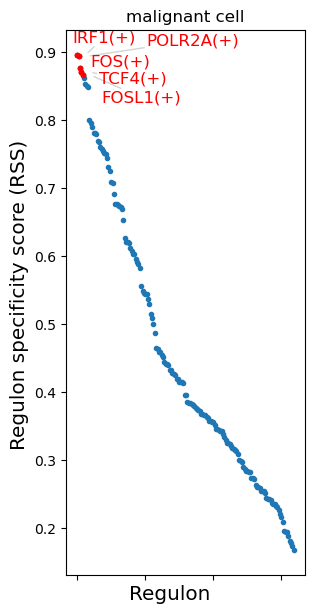

In [97]:
cats = list(adata.obs.cell_type.unique())

# Plot for the first category only
c = cats[0]
fig = plt.figure(figsize=(3, 6))

x = rss.T[c]
ax = fig.add_subplot(1, 1, 1)  # Only one subplot
plot_rss(rss, c, top_n=5, max_n=None, ax=ax)
ax.set_ylim(x.min() - (x.max() - x.min()) * 0.05, x.max() + (x.max() - x.min()) * 0.05)

for t in ax.texts:
    t.set_fontsize(12)
ax.set_ylabel('')
ax.set_xlabel('')
adjust_text(ax.texts, arrowprops=dict(arrowstyle='-', color='lightgrey'))

fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
    'figure.titlesize': 'large',
    'axes.labelsize': 'medium',
    'axes.titlesize': 'large',
    'xtick.labelsize': 'medium',
    'ytick.labelsize': 'medium'
})

# plt.savefig("PBMC10k_cellType-RSS-top5.pdf", dpi=600, bbox_inches="tight")
plt.show()